In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import mlflow
import mlflow.pytorch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
import numpy as np
import seaborn as sns
from itertools import product

# CIFAR-10 Label Names
CIFAR10_LABELS = [
    "Airplane", "Automobile", "Bird", "Cat", "Deer",
    "Dog", "Frog", "Horse", "Ship", "Truck"
]

# Define the Improved CNN Model with dropout as a hyperparameter
class ImprovedCNNModel(nn.Module):
    def __init__(self, dropout_prob):
        super(ImprovedCNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 2 * 2, 1024),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(1024, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Split data into training and validation
def load_data_with_validation(batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    full_train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    train_dataset, val_dataset = torch.utils.data.random_split(full_train_dataset, [40000, 10000])
    test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader

# Train the model and calculate F1 for training data
def train_model_with_f1(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

    f1 = f1_score(all_labels, all_predictions, average="weighted")
    return total_loss / len(train_loader), 100 * correct / total, f1

# Evaluate model with additional metrics
def evaluate_on_dataset_with_metrics(model, data_loader, criterion, device, num_classes=10):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average="weighted")
    return total_loss / len(data_loader), 100 * correct / total, f1, cm, all_labels, all_predictions

# Hyperparameter tuning
def hyperparameter_tuning(hyperparameter_space, device):
    best_val_f1 = 0
    best_hyperparams = None

    for params in hyperparameter_space:
        print(f"Evaluating hyperparameters: {params}")
        train_loader, val_loader, _ = load_data_with_validation(params["batch_size"])
        model = ImprovedCNNModel(params["dropout_prob"]).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=params["learning_rate"])
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

        for epoch in range(params["num_epochs"]):
            train_model_with_f1(model, train_loader, criterion, optimizer, device)
            _, _, val_f1, _, _, _ = evaluate_on_dataset_with_metrics(model, val_loader, criterion, device)

            print(f"Epoch {epoch + 1}/{params['num_epochs']}, Validation F1: {val_f1:.4f}")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_hyperparams = params

    print(f"Best hyperparameters: {best_hyperparams}, Best Validation F1: {best_val_f1:.4f}")
    return best_hyperparams

# Train and test final model with visualizations
def train_and_test_final_model_with_visualizations(best_hyperparams, device):
    train_loader, val_loader, test_loader = load_data_with_validation(best_hyperparams["batch_size"])
    model = ImprovedCNNModel(best_hyperparams["dropout_prob"]).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=best_hyperparams["learning_rate"])
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    for epoch in range(best_hyperparams["num_epochs"]):
        train_loss, train_acc, train_f1 = train_model_with_f1(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_f1, _, _, _ = evaluate_on_dataset_with_metrics(model, val_loader, criterion, device)

        print(
            f"Epoch {epoch + 1}/{best_hyperparams['num_epochs']}, "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Train F1: {train_f1:.4f}, "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val F1: {val_f1:.4f}"
        )

        scheduler.step()

    # Final evaluation
    test_loss, test_acc, test_f1, cm, all_labels, all_predictions = evaluate_on_dataset_with_metrics(
        model, test_loader, criterion, device
    )
    print(
        f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%, Test F1: {test_f1:.4f}"
    )

# Main Execution
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Define hyperparameter space
    learning_rates = [0.001, 0.0005]
    num_epochs_list = [15]
    batch_sizes = [64, 128]
    dropout_probs = [0.3, 0.5]
    hyperparameter_space = [
        {"learning_rate": lr, "num_epochs": ne, "batch_size": bs, "dropout_prob": dp}
        for lr, ne, bs, dp in product(learning_rates, num_epochs_list, batch_sizes, dropout_probs)
    ]

    # Perform hyperparameter tuning
    best_hyperparams = hyperparameter_tuning(hyperparameter_space, device)

    # Train the final model
    train_and_test_final_model_with_visualizations(best_hyperparams, device)


Evaluating hyperparameters: {'learning_rate': 0.001, 'num_epochs': 15, 'batch_size': 64, 'dropout_prob': 0.3}
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/15, Validation F1: 0.6759
Epoch 2/15, Validation F1: 0.7443
Epoch 3/15, Validation F1: 0.7694
Epoch 4/15, Validation F1: 0.7868
Epoch 5/15, Validation F1: 0.7801
Epoch 6/15, Validation F1: 0.7935
Epoch 7/15, Validation F1: 0.7955
Epoch 8/15, Validation F1: 0.7898
Epoch 9/15, Validation F1: 0.7843
Epoch 10/15, Validation F1: 0.7878
Epoch 11/15, Validation F1: 0.7861
Epoch 12/15, Validation F1: 0.7806
Epoch 13/15, Validation F1: 0.7917
Epoch 14/15, Validation F1: 0.7956
Epoch 15/15, Validation F1: 0.7997
Evaluating hyperparameters: {'learning_rate': 0.001, 'num_epochs': 15, 'batch_size': 64, 'dropout_prob': 0.5}
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/15, Validation F1: 0.6610
Epoch 2/15, Validation F1: 0.7278
Epoch 3/15, Validation F1: 0.7687
Epoch 4/15

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/15, Train Loss: 1.2468, Train Acc: 55.43%, Train F1: 0.5521, Val Loss: 0.9142, Val Acc: 67.30%, Val F1: 0.6680, Test Loss: 0.9433, Test Acc: 65.86%, Test F1: 0.6529
Epoch 2/15, Train Loss: 0.8069, Train Acc: 71.76%, Train F1: 0.7166, Val Loss: 0.7596, Val Acc: 74.51%, Val F1: 0.7491, Test Loss: 0.7724, Test Acc: 73.26%, Test F1: 0.7368
Epoch 3/15, Train Loss: 0.6105, Train Acc: 78.75%, Train F1: 0.7870, Val Loss: 0.7319, Val Acc: 75.44%, Val F1: 0.7511, Test Loss: 0.7621, Test Acc: 74.85%, Test F1: 0.7451
Epoch 4/15, Train Loss: 0.4576, Train Acc: 84.04%, Train F1: 0.8401, Val Loss: 0.6837, Val Acc: 77.41%, Val F1: 0.7781, Test Loss: 0.7159, Test Acc: 76.28%, Test F1: 0.7672
Epoch 5/15, Train Loss: 0.3447, Train Acc: 88.09%, Train F1: 0.8808, Val Loss: 0.6607, Val Acc: 79.36%, Val F1: 0.7938, Test Loss: 0.6776, Test Acc: 78.92%, Test F1: 0.7893
Epoch 6/15, Train Loss: 0.1461, Train Acc: 94.99%, Train F1

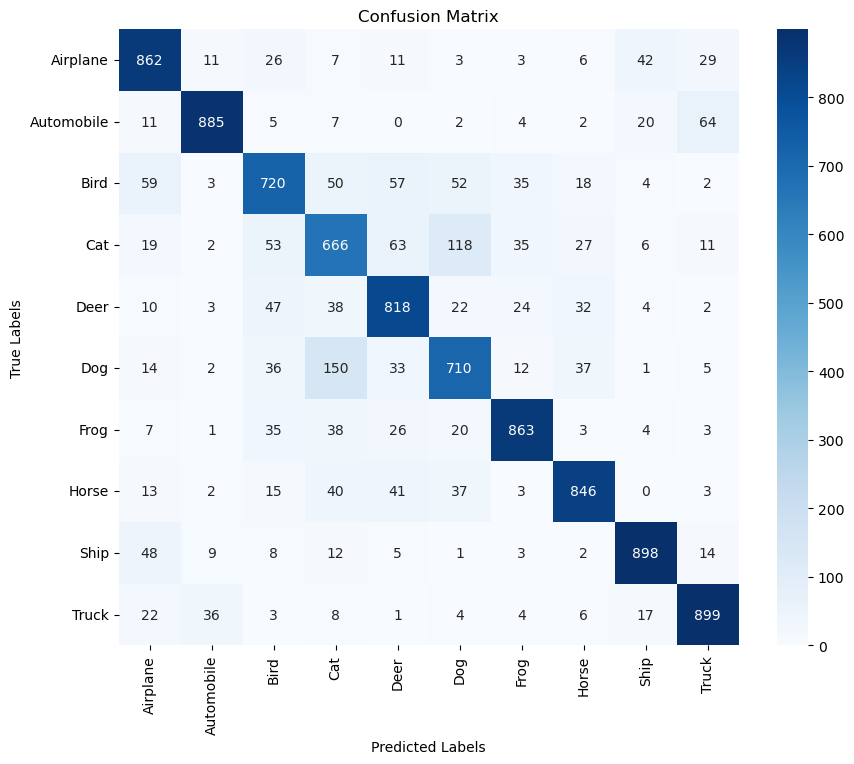

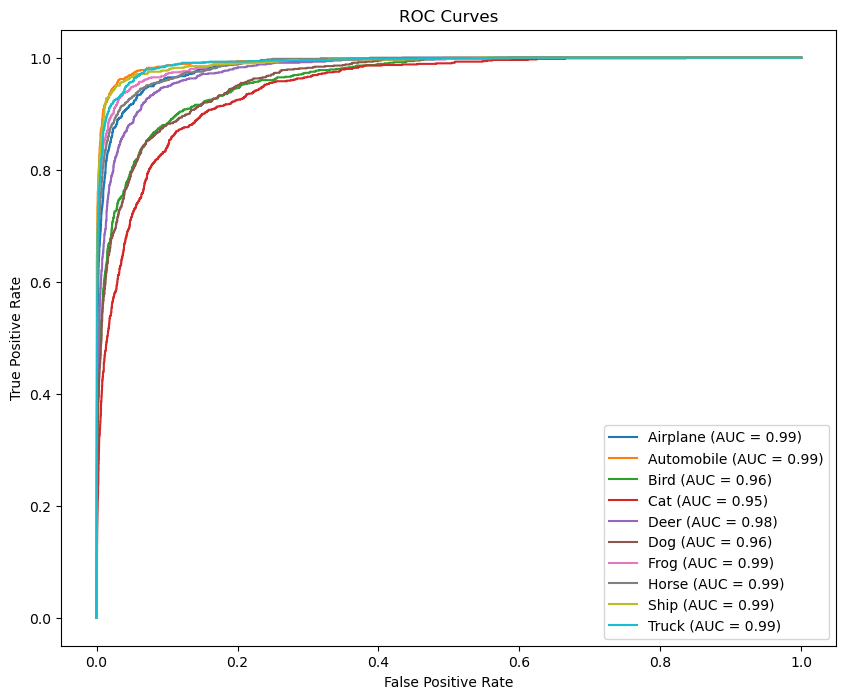

2024/12/09 09:22:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import mlflow
import mlflow.pytorch

# CIFAR-10 Label Names
CIFAR10_LABELS = [
    "Airplane", "Automobile", "Bird", "Cat", "Deer",
    "Dog", "Frog", "Horse", "Ship", "Truck"
]

# Define the Improved CNN Model
class ImprovedCNNModel(nn.Module):
    def __init__(self, dropout_prob):
        super(ImprovedCNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 2 * 2, 1024),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(1024, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Load CIFAR-10 data
def load_data_with_validation(batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    full_train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    train_dataset, val_dataset = torch.utils.data.random_split(full_train_dataset, [40000, 10000])
    test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader

# Train the model
def train_model_with_f1(model, data_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

    f1 = f1_score(all_labels, all_predictions, average="weighted")
    return total_loss / len(data_loader), 100 * correct / total, f1, all_labels, all_predictions

# Evaluate model
def evaluate_model_with_metrics(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    all_probs = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probs.extend(probs)

    cm = confusion_matrix(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average="weighted")
    return total_loss / len(data_loader), 100 * correct / total, f1, cm, all_labels, all_predictions, np.array(all_probs)

# Train and test final model
def train_and_test_final_model_with_logging(device):
    # Hyperparameters
    batch_size = 128
    dropout_prob = 0.5
    learning_rate = 0.001
    num_epochs = 15

    train_loader, val_loader, test_loader = load_data_with_validation(batch_size)
    model = ImprovedCNNModel(dropout_prob).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    # MLflow setup
    mlflow.set_experiment("Improved CNN Experiment")
    with mlflow.start_run():
        # Log hyperparameters
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("num_epochs", num_epochs)

        for epoch in range(num_epochs):
            train_loss, train_acc, train_f1, _, _ = train_model_with_f1(model, train_loader, criterion, optimizer, device)
            val_loss, val_acc, val_f1, cm, all_labels, all_predictions, all_probs = evaluate_model_with_metrics(model, val_loader, criterion, device)
            test_loss, test_acc, test_f1, cm, all_labels, all_predictions, all_probs = evaluate_model_with_metrics(model, test_loader, criterion, device)

            # Log metrics to MLflow
            mlflow.log_metric("train_loss", train_loss, step=epoch)
            mlflow.log_metric("train_accuracy", train_acc, step=epoch)
            mlflow.log_metric("train_f1", train_f1, step=epoch)

            mlflow.log_metric("val_loss", val_loss, step=epoch)
            mlflow.log_metric("val_accuracy", val_acc, step=epoch)
            mlflow.log_metric("val_f1", val_f1, step=epoch)

            mlflow.log_metric("test_loss", test_loss, step=epoch)
            mlflow.log_metric("test_accuracy", test_acc, step=epoch)
            mlflow.log_metric("test_f1", test_f1, step=epoch)

            print(
                f"Epoch {epoch + 1}/{num_epochs}, "
                f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Train F1: {train_f1:.4f}, "
                f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val F1: {val_f1:.4f}, "
                f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%, Test F1: {test_f1:.4f}"
            )

            scheduler.step()

        # Final evaluation on test set
        test_loss, test_acc, test_f1, cm, all_labels, all_predictions, all_probs = evaluate_model_with_metrics(
            model, test_loader, criterion, device
        )
        print(
            f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%, Test F1: {test_f1:.4f}"
        )

        # Log confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CIFAR10_LABELS, yticklabels=CIFAR10_LABELS)
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.title("Confusion Matrix")
        plt.savefig("confusion_matrix.png")
        plt.show()
        mlflow.log_artifact("confusion_matrix.png")

        # ROC Curves
        plt.figure(figsize=(10, 8))
        for i in range(len(CIFAR10_LABELS)):
            fpr, tpr, _ = roc_curve((np.array(all_labels) == i).astype(int), all_probs[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{CIFAR10_LABELS[i]} (AUC = {roc_auc:.2f})")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curves")
        plt.legend(loc="best")
        plt.savefig("roc_curves.png")
        plt.show()
        mlflow.log_artifact("roc_curves.png")

        # Log model
        mlflow.pytorch.log_model(model, "model")

# Main execution
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_and_test_final_model_with_logging(device)
